## DISPLAY VIDEO


In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(video):
    fig = plt.figure(figsize=(3,3))  #Display size specification

    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

# CREATE DATASET

In [1]:
# Import lib's
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
import cv2
import glob
import os
path="/content/DEMETER/TRAINING/PLANT-CONCRETE-PREP/"

In [2]:
#call set from github
!git clone https://github.com/christiantorres29/DEMETER.git

Cloning into 'DEMETER'...
remote: Enumerating objects: 8107, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 8107 (delta 9), reused 80 (delta 9), pack-reused 8025
Receiving objects: 100% (8107/8107), 91.44 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (8081/8081), done.


CONVERT DATA TO DATASET

In [3]:
input_shape = cv2.imread("/content/DEMETER/TRAINING/PLANT-CONCRETE-PREP/40/0.png").shape[0:2]
print("image shape: "+str(input_shape))

batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    label_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    image_size=input_shape,
    validation_split=0.2,
    subset="both",
    seed=42,
)
# Print the class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

input_shape=input_shape+(1,)
print(input_shape)

print(train_ds.element_spec)

image shape: (480, 640)
Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
Class names: ['100', '110', '120', '40', '60', '70', '80', '90']
Number of classes: 8
(480, 640, 1)
(TensorSpec(shape=(None, 480, 640, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))


In [4]:
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (320,240)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (320,240)), y))

In [5]:
input_shape=(320,240,1)

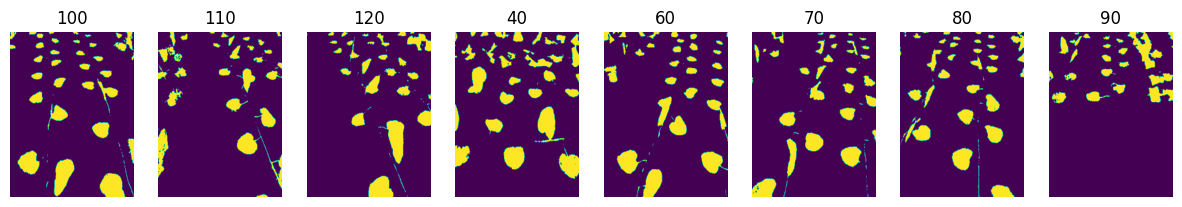

In [6]:
#class_names = train_ds.class_names
num_classes = len(class_names)
images = []
labels = []

for image_batch, label_batch in train_ds.as_numpy_iterator():
    for image, label in zip(image_batch, label_batch):
        class_index = np.argmax(label)
        if len(images) < num_classes and class_index == len(images):
            images.append(image)
            labels.append(class_names[class_index])
        if len(images) == num_classes:
            break
    if len(images) == num_classes:
        break

fig, axs = plt.subplots(1, num_classes, figsize=(15, 15))
for i in range(num_classes):
    axs[i].imshow(images[i].astype('uint8'))
    axs[i].set_title(labels[i])
    axs[i].axis('off')
plt.show()

# APPLY NEURAL NETWORK

In [7]:
def make_testmodel(input_shape, num_classes):
    x = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return x

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [8]:
model = make_testmodel(input_shape=input_shape, num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 238, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 119, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 58, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 289536)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [9]:
epochs = 25

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=50,
    callbacks=callbacks,
    validation_data=val_ds
)


Epoch 1/25
50/50 [==============================] - 37s 428ms/step - loss: 68.0169 - accuracy: 0.2086 - val_loss: 1.8692 - val_accuracy: 0.2331
Epoch 2/25
50/50 [==============================] - 24s 441ms/step - loss: 1.8010 - accuracy: 0.2603 - val_loss: 1.7516 - val_accuracy: 0.2569
Epoch 3/25
50/50 [==============================] - 23s 432ms/step - loss: 1.6924 - accuracy: 0.2734 - val_loss: 1.6287 - val_accuracy: 0.2706
Epoch 4/25
50/50 [==============================] - 23s 404ms/step - loss: 1.5295 - accuracy: 0.3131 - val_loss: 1.4806 - val_accuracy: 0.3319
Epoch 5/25
50/50 [==============================] - 24s 440ms/step - loss: 1.2473 - accuracy: 0.4528 - val_loss: 1.1642 - val_accuracy: 0.5350
Epoch 6/25
50/50 [==============================] - 22s 412ms/step - loss: 0.8464 - accuracy: 0.6502 - val_loss: 0.9118 - val_accuracy: 0.6606
Epoch 7/25
50/50 [==============================] - 22s 418ms/step - loss: 0.5439 - accuracy: 0.7894 - val_loss: 0.6163 - val_accuracy: 0.788

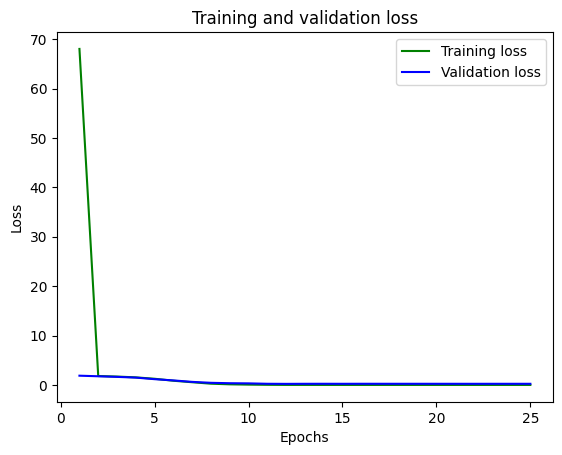

In [10]:
# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

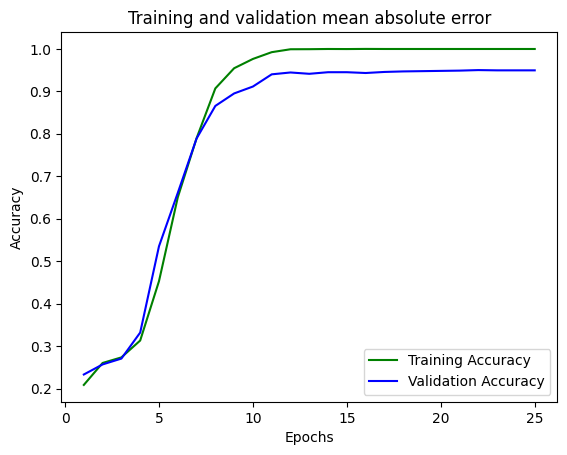

In [11]:
accuracy = history.history['accuracy']
val_accu = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accu, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
model.save('my_model')

In [14]:
model.save('my_model.h5')

In [13]:
!zip -r my_model.zip my_model/

  adding: my_model/ (stored 0%)
  adding: my_model/saved_model.pb (deflated 88%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: my_model/variables/variables.index (deflated 62%)
  adding: my_model/keras_metadata.pb (deflated 90%)
  adding: my_model/assets/ (stored 0%)
  adding: my_model/fingerprint.pb (stored 0%)


2/2 [==============================] - 0s 17ms/step


<Axes: >

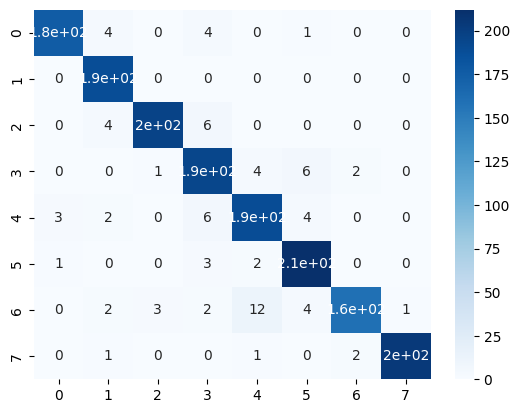

In [15]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load the test dataset
"""
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'test_dir',
    image_size=(320,240),
    batch_size=32
)
"""
test_dataset=val_ds

# load the saved model
#model = tf.keras.models.load_model('my_model.h5')

# make predictions on the test dataset
y_pred = []
y_true = []
for images, labels in test_dataset:
    y_pred.extend(np.argmax(model.predict(images), axis=1))
    y_true.extend(np.argmax(labels, axis=1))

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')


In [32]:
import tensorflow as tf
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    "/content/DEMETER/TRAINING/PLANT-CONCRETE-PREP/70/525.png",color_mode='grayscale', target_size=(320,240)
)

# convert the image to a numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array.reshape((-1, 320, 240, 1))

In [33]:
img_array.shape

(1, 320, 240, 1)

In [34]:
# make a prediction on the image array
predictions = model.predict(img_array)

# print the predicted class
predicted_class = np.argmax(predictions[0])
print(class_names[predicted_class])

1/1 [==============================] - 0s 125ms/step
70
